# Exploring regularization for linear regression

## Goal

The goal of this lab is to explore the effect of regularization on the coefficients and accuracy of linear regression models for a toy dataset downloaded from Kaggle (the machine learning competition site).

## Get Ames data set and set up

Log into Kaggle and get [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). A useful discussion on this data set is [here](https://nycdatascience.com/blog/student-works/machine-learning-project/).

In [35]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.datasets import load_wine, load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'svg'

## Load data, drop columns with missing values, one-hot encode categoricals

In [36]:
df_ames = pd.read_csv("ames.csv")
df_ames.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [37]:
# ignore columns with missing values for this exercise
cols_with_missing = df_ames.columns[df_ames.isnull().any()]
cols = set(df_ames.columns) - set(cols_with_missing)

X = df_ames[cols]
X = X.drop('SalePrice', axis=1)
y = df_ames['SalePrice']

X = pd.get_dummies(X) # dummy encode categorical variables
X.shape

(1460, 216)

## Examine coefficients of nonregularized OLS model

**1. Split off validation/test set and train unregularized linear regression model**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [39]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

**2. Compare the R^2 on training and test set**

In [40]:
print(f"{lm.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lm.score(X_test, y_test):.2f} R^2 on test set")

0.93 R^2 on training set
0.26 R^2 on test set


**3. Predict $\overline{y}$ computed from training set instead of using the model; what is the R^2? on test set?**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.

In [41]:
y_pred = np.full(shape=(len(y_test),1), fill_value=np.mean(y_train)) # get vector of y_train bar
r2_score(y_pred, y_test) # how well do we predict y_test using y_train bar?

-5.459265536609544e+30

**4. Extract $\beta_0, ..., \beta_p$**

In [42]:
lm_beta = lm.coef_

In [43]:
sum(np.abs(lm_beta) < 1e-5) # how many close to 0?

5

**5. Plot the coefficient index versus the value**

R^2 should give 0 as the neutral value when the prediction is no better and no worse than simply predicting the average of the training set.  The coefficients should look something like the following images, depending on which training samples are chosen:

<img src="ames-ols.png" width="300"><img src="ames-ols-2.png" width="300">

The following function is a handy way to plot the coefficients.

In [44]:
def plotbeta(beta, which, yrange=(-20_000, 20_000),fontsize=10, xlabel=True, ylabel=True, ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(4,2.5))
    ax.bar(range(len(beta)),beta)
    if xlabel:
        ax.set_xlabel("Coefficient $\\beta_i$ for $i \\geq 1$", fontsize=fontsize)
    if ylabel:
        ax.set_ylabel("Coefficient value", fontsize=fontsize)
    if yrange is not None:
        ax.set_ylim(*yrange)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:.0f}'))
    ax.set_title(f"{which} $\\overline{{\\beta}}$={np.mean(beta):.0f}, $\\sigma(\\beta)$={np.std(beta):.1f}", fontsize=fontsize)

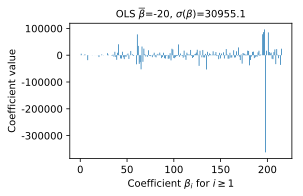

In [45]:
plotbeta(lm_beta, "OLS", yrange=None)
#plt.tight_layout(); plt.savefig("ames-ols.png",dpi=150,bbox_inches=0)

## Regularization

Both L1 and L2 regularization benefit from normalizing variables; sklearn has an option to do this as part of the training process, but let's do it explicitly as a way to get started.

In [46]:
def normalize(X): # well, I'm creating standard variables here (u-x)/sigma
    X = X.copy()
    for colname in X.columns:
        u = np.mean(X[colname])
        s = np.std(X[colname])
        if s>0.0:
            X[colname] = (X[colname] - u) / s
        else:
            X[colname] = (X[colname] - u)
    return X

In [47]:
X_train.iloc[:,0:8].head(1)  # unnormalized values

,BsmtHalfBath,OverallCond,3SsnPorch,Id,MoSold,GarageCars,OpenPorchSF,BsmtFinSF1
1054,0,5,0,1055,11,2,60,932


In [48]:
X_train = normalize(X_train)
X_test = normalize(X_test)

In [49]:
X_train.iloc[:,0:8].head(1)  # These values should be normalized

,BsmtHalfBath,OverallCond,3SsnPorch,Id,MoSold,GarageCars,OpenPorchSF,BsmtFinSF1
1054,-0.248633,-0.523614,-0.117701,0.762139,1.709395,0.303379,0.180881,1.111403


In [50]:
lmbda = 5

## L1 (Lasso) regularization

**1. Train an L1 (lasso) linear regression model using lmbda**

Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.

In [62]:
lasso = Lasso(alpha=lmbda, tol=.1)
lasso.fit(X_train, y_train)

Lasso(alpha=2000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.1, warm_start=False)

<details>
<summary>Solution</summary>
<pre>
lasso = Lasso(alpha=lmbda, tol=.1)
lasso.fit(X_train, y_train)
</pre>
</details>

**2. Examine the training and testing scores**

Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.

In [63]:
print(f"{lasso.score(X_train, y_train):.2f} R^2 on training set")
print(f"{lasso.score(X_test, y_test):.2f} R^2 on test set")

0.91 R^2 on training set
0.52 R^2 on test set


**Q.** Why is the testing score much worse?

<details>
<summary>Solution</summary>
</details>

**3.  Count how many $\beta_{1..p}$ coefficients are (close to) zero**

Note: `sum(np.abs(x) < 1e-5)` is a decent way to check for values of `x` close to zero but not necessarily zero.  There is also `numpy.isclose()` but that is too strict (requires numbers to be really close to zero) for this exercise.

In [64]:
sum(np.abs(lasso.coef_) < 1e-5) # how many close to 0?

173

<details>
<summary>Solution</summary>
<pre>
lasso_beta = lasso.coef_
sum(np.abs(lasso_beta) < 1e-5) # how many close to 0?
</pre>
</details>

**4. Plot the  $\beta_{1..p}$ coefficients using `plotbeta`**

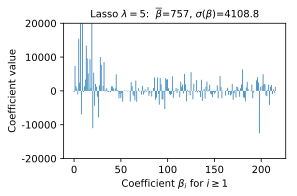

In [54]:
plotbeta(lasso.coef_, "Lasso $\lambda="+str(lmbda)+"$: ")

## L2 (Ridge) regularization

**1. Train an L2 (Ridge) linear regression model using lmbda**

Note that the sklearn model constructors call the parameter `alpha` not `lmbda`.

In [55]:
ridge = Ridge(alpha=lmbda)
ridge.fit(X_train, y_train)

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

<details>
<summary>Solution</summary>
<pre>
ridge = Ridge(alpha=lmbda)
ridge.fit(X_train, y_train)
</pre>
</details>

**2. Examine the training and testing scores**

In [56]:
print(f"{ridge.score(X_train, y_train):.2f} R^2 on training set")
print(f"{ridge.score(X_test, y_test):.2f} R^2 on test set")

0.93 R^2 on training set
0.49 R^2 on test set


**Q.**  Why are the R^2 scores for L2 similar to L1?

<details>
<summary>Solution</summary>
</details>

**3.  Count how many $\beta_{1..p}$ coefficients are (close to) zero**

In [57]:
sum(np.abs(ridge.coef_) < 1e-5) # how many close to 0?

5

**4. Plot the  $\beta_{1..p}$ coefficients using `plotbeta`**

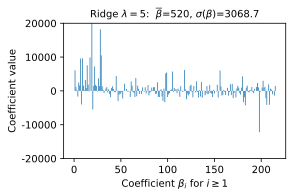

In [58]:
plotbeta(ridge.coef_, "Ridge $\lambda="+str(lmbda)+"$: ")

## Effect of $\lambda$ on regularization and R^2 scores

The goal of the following code snippets is to help you visualize how the $\lambda$ regularization parameter affects model parameters and associated training and testing scores. There are a number of important questions to answer following the code snippets.

lambda=   1: Zeros   8: train R^2 0.92 test R^2 0.37
lambda=  10: Zeros  11: train R^2 0.92 test R^2 0.37
lambda= 100: Zeros  28: train R^2 0.92 test R^2 0.39
lambda= 200: Zeros  52: train R^2 0.92 test R^2 0.41
lambda= 500: Zeros  94: train R^2 0.92 test R^2 0.45
lambda=1000: Zeros 139: train R^2 0.92 test R^2 0.49
lambda=2000: Zeros 173: train R^2 0.91 test R^2 0.52


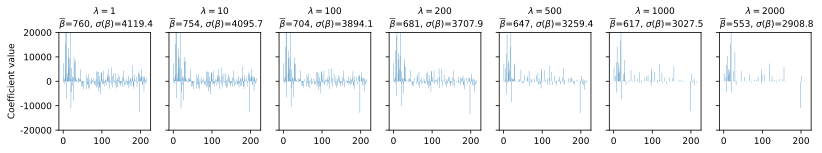

In [59]:
fig,axes = plt.subplots(1,7,figsize=(13.5,1.8), sharey=True)
for i,lmbda in enumerate([1,10,100,200,500,1000,2000]):
    lasso = Lasso(alpha=lmbda, tol=.1)
    lasso.fit(X_train, y_train)
    r2 = lasso.score(X_train, y_train)
    r2t = lasso.score(X_test, y_test)
    print(f"lambda={lmbda:4d}: Zeros {sum(np.abs(lasso.coef_) < 1e-5):3d}: train R^2 {r2:.2f} test R^2 {r2t:.2f}")
    plotbeta(lasso.coef_, f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0)

**Q.** Why does the training R^2 score go down as we increase lambda?

<details>
<summary>Solution</summary>
</details>

**Q.** Why does the L1 testing R^2 score go up we increase lambda?

<details>
<summary>Solution</summary>
</details>

**Q.** Describe what is happening to the L1 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
</details>

lambda=   1: Zeros 5: train R^2 0.93 test R^2 0.48
lambda=  10: Zeros 5: train R^2 0.93 test R^2 0.49
lambda= 100: Zeros 5: train R^2 0.93 test R^2 0.55
lambda= 200: Zeros 5: train R^2 0.93 test R^2 0.59
lambda= 500: Zeros 5: train R^2 0.91 test R^2 0.65
lambda=1000: Zeros 5: train R^2 0.90 test R^2 0.70
lambda=2000: Zeros 5: train R^2 0.87 test R^2 0.74


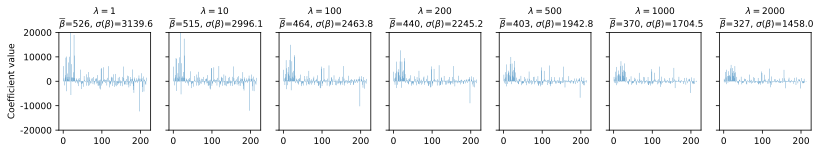

In [60]:
fig,axes = plt.subplots(1,7,figsize=(13.5,1.8), sharey=True)
for i,lmbda in enumerate([1,10,100,200,500,1000,2000]):
    ridge = Ridge(alpha=lmbda, tol=.1)
    ridge.fit(X_train, y_train)
    r2 = ridge.score(X_train, y_train)
    r2t = ridge.score(X_test, y_test)
    print(f"lambda={lmbda:4d}: Zeros {sum(np.abs(ridge.coef_) < 1e-5)}: train R^2 {r2:.2f} test R^2 {r2t:.2f}")
    plotbeta(ridge.coef_, f"$\\lambda={lmbda}$\n", ax=axes[i], fontsize=9, xlabel=False, ylabel=i==0)

**Q.** Why does the training R^2 score go down as we increase lambda?

<details>
<summary>Solution</summary>
</details>

**Q.** Why does the L2 testing R^2 score go up we increase lambda and then start to go back down?

<details>
<summary>Solution</summary>
</details>

**Q.** Describe what is happening to the L2 coefficients as we increase lambda?

<details>
<summary>Solution</summary>
</details>

**Q.** Visually, how do the magnitudes of the L1 and L2 coefficients compare?

<details>
<summary>Solution</summary>
</details>